In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import chromadb
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
#Import library code
import helper_code.dataloading as dataloading
import helper_code.model_functions as model_functions
import helper_code.data_vis as data_vis

d:\Projects\DSC180A-Capstone\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(2346)

In [3]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

100%|██████████| 7490/7490 [00:01<00:00, 6558.47it/s]


In [4]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [5]:
train_embeddings, train_labels, _, _  = dataloading.load_full_embeddings(train, "train_embeddings")

test_embeddings, test_labels, _, _  = dataloading.load_full_embeddings(test, "test_embeddings")

In [6]:
train_embedding_dataset = dataloading.CustomEmbeddingDataset(train_embeddings, train_labels)
test_embedding_dataset = dataloading.CustomEmbeddingDataset(test_embeddings, test_labels)

train_embedding_dataloader = DataLoader(train_embedding_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_embedding_dataloader = DataLoader(test_embedding_dataset, batch_size=64, shuffle=True, pin_memory=True)

In [7]:
device = "cuda"

encoder = model_functions.create_encoder()
encoder.to(device);

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
encoder.load_state_dict(torch.load('weights/model_weights_camera_10-27-25.pth', weights_only=True))
encoder.eval();

In [9]:
classification_head = model_functions.ClassificationHead()
classification_head.to(device)

ClassificationHead(
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classification_head.parameters(), lr=1e-4) # Optimize only the new head

In [ ]:
ead_criterion = nn.CrossEntropyLoss()
head_optimizer = optim.Adam(classification_head.parameters(), lr=1e-4) # Optimize only the new head



num_epochs = 1
for epoch in range(num_epochs):
    classification_head.train() # Set model to training mode

    for batch in tqdm(train_embedding_dataloader, desc = f"Processing batches in epoch {epoch}"):
        embeddings = batch['embeddings'].to(device).float()
        labels = batch['labels'].to(device).long()

        head_optimizer.zero_grad()
        outputs = classification_head(embeddings)
        loss = head_criterion(outputs, labels)
        loss.backward()
        head_optimizer.step()
torch.save(classification_head.state_dict(), head_name)


#Report training and validation accuracy
classification_head.eval()

print("Classification head training complete.")
#Report training and validation accuracy


def get_accuracy(embeddings, labels, model):
    embeddings_tensor = torch.Tensor(embeddings.to_numpy()).to(device)

    outputs = model(embeddings_tensor)

    labels_tensor = torch.Tensor(labels).to(device)

    accuracy = (torch.argmax(outputs, dim = -1) == labels_tensor).float().mean().item()

    return accuracy


print(f"Training accuracy: {get_accuracy(train_embeddings, train_labels, classification_head)}")
print(f"Test accuracy: {get_accuracy(val_embeddings, val_labels, classification_head)}")



In [10]:
classification_head.load_state_dict(torch.load('weights/model_weights_camera_10-27-25_head.pth', weights_only=True))

<All keys matched successfully>

In [18]:
embeddings_tensor = torch.Tensor(test_embeddings.to_numpy()).to(device)

outputs = classification_head(embeddings_tensor).detach()

labels_tensor = torch.Tensor(test_labels).to(device)

accuracy = (torch.argmax(outputs, dim = -1) == labels_tensor).float().mean().item()

print(accuracy)

0.884512722492218


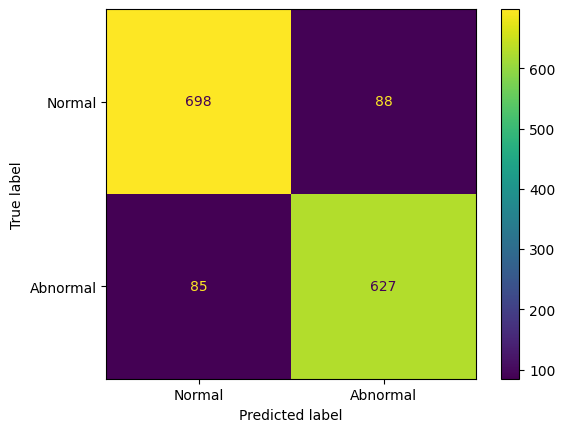

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = torch.argmax(outputs, dim = -1).cpu().numpy()


cm = confusion_matrix(test_labels.to_numpy(), preds)
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Abnormal"]).plot()

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, embeddings, labels)

plt.show()